# Active Learning for Level Set Estimation of Black Box functions

Talk for [PyHEP2021](https://indico.cern.ch/event/1019958/) by [Irina Espejo](https://irinaespejo.github.io/)

Work by [Lukas Heinrich](http://www.lukasheinrich.com/), [Gilles Louppe](https://glouppe.github.io/), [Irina Espejo](https://irinaespejo.github.io/), [Patrick Rieck](https://inspirehep.net/authors/1078568) and [Kyle Cranmer](http://theoryandpractice.org/)

<img src="../assets/thankyou.jpg" alt="Coauthors" title="Co-authors" width="550" height="300" />

## TOC
* [1. What is this about?](#1)
* [2. Setting of the problem](#2)
* [3. Specify the Gaussian Process prior](#3)
* * [3.1. Casual user](#3.1)
* * [3.2. Advanced](#3.2)
* [4. Initialize excursion](#4)
* [5. Active Learning](#5)
* [6. 2D example](#2d)
* [7. 4D example](#4d)
* [7. Further work](#further)

## 1. What is this about and why do I care? <a class="anchor" id="1"></a>

- We care because this <bottom arrow> type of plot is the end step of a HEP experimental analysis. 
  
  They are also incredibly expensive to produce, evaluating each point has high latency of days or weeks. 
  
  **That is why we want to query the simulators pipeline as few times as possible while having an accurate estimation of the level sets**.
  

  <img src="../assets/ATLAS_contour.png" alt="Contour" title="A typical exclusion plot for a HEP analysis" width="400" height="400" class="center" />


- The computational cost of the black box limits granularity and dimensionality of 
  scans and the quality of exclusion regions.



- _What can we do to scale this process up_? This tutorial shows how to use `excursion`. 
  
  It is a confluence of Active Learning with Gaussian Process Regression with [GPytorch](https://gpytorch.ai/) support

## 2. Setting of the problem <a class="anchor" id="2"></a>

put here a diagram showing truth level reco level all the typical pipeline steps and then say this is gonna be our f black box function and here parameters and here the CLs or p-values.

### Formal setting

<div class="alert alert-block alert-info">

We have a black box function $f_{BB}(\theta): \mathbb{R}^d \rightarrow \mathbb{R}$ and a threshold $t \in \mathbb{R}$. 


Each evaluation $f_{BB}(\theta_0)$ takes a long long time to process.


We want to find the level set $E_t(f_{BB}) = \{ \theta \in \mathbb{R}^d | f_{BB}(\theta) = t\}$


with as few queries to $f_{BB}$ as possible

</div>

### Comparison with Bayesian Optimization
Our method might seem the same as Bayesian Optimization in structure.
But, our target set is a curve not a point.

<img src="../assets/BO.jpg" alt="BO" title="Comparison" width="650" height="350" class="center" />

There are useful packages that implement Bayesian Optimization methods 
that have inspired our library:

    - Scikit-optimize [link](https://scikit-optimize.github.io/stable/) with
  
    an Ask & Tell API and based on scikit-learn

    - BoTorch [link](https://botorch.org/) with a step API an based on [GPyTorch](https://gpytorch.ai/) which at its time is based on Torch.




                  Let's start with a 1D example to have better visualizations. 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.warnings.filterwarnings('ignore')

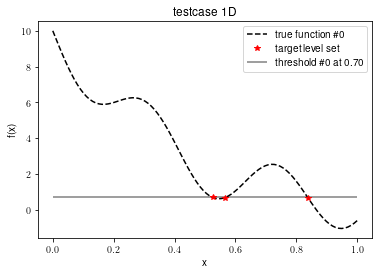

In [3]:
# import testcase 
import excursion
import excursion.testcases.fast_1D as testcase_1d

#plot testcase 
from excursion.plotting import plot_testcase_1d
plot_testcase_1d(testcase_1d, tol=0.05)

## 3. Specify the Gaussian Process prior

We use a Gaussian Process as a surrogate model for the Black Box function.
Gaussian Processes are non-parametric models where inductive bias is specified by the choice of mean and kernel. The observational model is specified by the likelihood.
GPyTorch has support for these [means](https://docs.gpytorch.ai/en/stable/means.html), [kernels](https://docs.gpytorch.ai/en/stable/kernels.html), [likelihoods](https://docs.gpytorch.ai/en/stable/models.html) and [inference models](https://docs.gpytorch.ai/en/stable/models.html)

We will use a constant mean, an RBF kernel $k(X, X') = C \exp{\left( -\frac{|| X-X' ||^2}{2l^2} \right)}$ and Exact Inference (no noise is added to the Black Box observation)

We anticipate two types of users:

- Casual user for out-of-the-box usage and small tweaks
  
- Advanced user who wants to have full control of all the moving parts _without_ messing with       source code

### 3.1 Casual user

In [4]:
#load pre-existent algorithm options
import yaml
file = open('../excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)

In [5]:
#is there GPU?
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

#initialize likelihood and GP with out-of-the-box options selected before
from excursion import init_gp
models, likelihood = init_gp(testcase_1d,             \
                             algorithm_opts,          \
                             device)

X_init  tensor([0.2020, 0.7980], dtype=torch.float64)
y_init  [tensor([5.9994, 1.6323], dtype=torch.float64)]


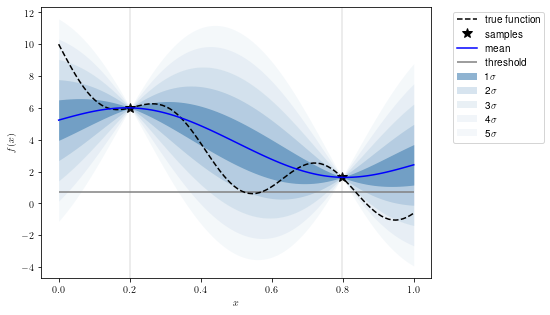

In [6]:
#plot gaussian process initialization
import excursion.plotting.onedim as plots
model = models[0]
plots.plot_GP(model, testcase_1d)

### 3.2 Advanced user

In [7]:
# FOR REFERENCE ONLY
# we will use the out of the box approach for the PyHEP21 tutorial
'''
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#initialize likelihood and GP
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

#plot gaussian process initialization
import excursion.plotting.onedim as plots
plots.plot_GP(model, testcase_1d)
'''


'\nimport gpytorch\n\nclass ExactGPModel(gpytorch.models.ExactGP):\n    def __init__(self, train_x, train_y, likelihood):\n        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)\n        self.mean_module = gpytorch.means.ConstantMean()\n        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())\n\n    def forward(self, x):\n        mean_x = self.mean_module(x)\n        covar_x = self.covar_module(x)\n        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)\n\n#initialize likelihood and GP\nlikelihood = gpytorch.likelihoods.GaussianLikelihood()\nmodel = ExactGPModel(train_x, train_y, likelihood)\n\n# fit hyperparameters\nmodel.train()\nlikelihood.train()\nexcursion.fit_hyperparams(model,likelihood)\n\n#plot gaussian process initialization\nimport excursion.plotting.onedim as plots\nplots.plot_GP(model, testcase_1d)\n'

## 4. Initialize  Excursion Set Estimator <a class="anchor" id="4"></a>

The `ExcursionSetExtimator()`  object keeps internal track of the status of the Level Set Estimation.

For instance, stores the "next evaluation" suggestions, queries the black box and updates the Gaussian Process posterior.

In [8]:
from excursion import ExcursionSetEstimator
estimator = ExcursionSetEstimator(testcase_1d,    \
                                  algorithm_opts, \
                                  models,         \
                                  likelihood,     \
                                  device)

## 5. Active Learning <a class="anchor" id="5"></a>

Now we will find which is the next point to query through the black box function.

In [9]:
import os 
import datetime

#save results in folder
n_updates = algorithm_opts['nupdates']
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y_%H:%M:%S") + "/"
outputfolder = "../examples/results/" +  timestampStr
os.makedirs(outputfolder)

In [10]:
%%capture wontshutup --no-stderr

for iteration in range(1, n_updates+1):    
    #take a step forward: find new points to evaluate
    estimator.step(testcase_1d, algorithm_opts, models, likelihood)
    #plot the new status
    estimator.plot_status(
            testcase_1d, algorithm_opts, models, estimator.acq_values, outputfolder);
    
    #update the posterior of the GP wrt the new points
    models = estimator.update_posterior(testcase_1d, algorithm_opts, models, likelihood)
    
    #get diagnostics (accuracy metric)
    estimator.get_diagnostics(testcase_1d, models, likelihood)
    
#save results
estimator.print_results(outputfolder, testcase_1d, algorithm_opts)


In [11]:
print(wontshutup)

Iteration  1
x_new tensor([[0.9697]], dtype=torch.float64)
pct  0.94
Iteration  2
x_new tensor([[0.8485]], dtype=torch.float64)
pct  0.95
Iteration  3
x_new tensor([[0.]], dtype=torch.float64)
pct  0.95
Iteration  4
x_new tensor([[0.4242]], dtype=torch.float64)
pct  0.95
Iteration  5
x_new tensor([[0.0101]], dtype=torch.float64)
pct  0.95
Iteration  6
x_new tensor([[0.5455]], dtype=torch.float64)
pct  0.99
Iteration  7
x_new tensor([[0.5253]], dtype=torch.float64)
pct  1.0
Iteration  8
x_new tensor([[0.0202]], dtype=torch.float64)
pct  1.0
Iteration  9
x_new tensor([[0.0303]], dtype=torch.float64)
pct  1.0
Iteration  10
x_new tensor([[0.0404]], dtype=torch.float64)
pct  1.0
Iteration  11
x_new tensor([[0.0505]], dtype=torch.float64)
pct  1.0
Iteration  12
x_new tensor([[0.0606]], dtype=torch.float64)
pct  1.0
Iteration  13
x_new tensor([[0.0707]], dtype=torch.float64)
pct  1.0
Iteration  14
x_new tensor([[0.0808]], dtype=torch.float64)
pct  1.0
Iteration  15
x_new tensor([[0.0909]], dt

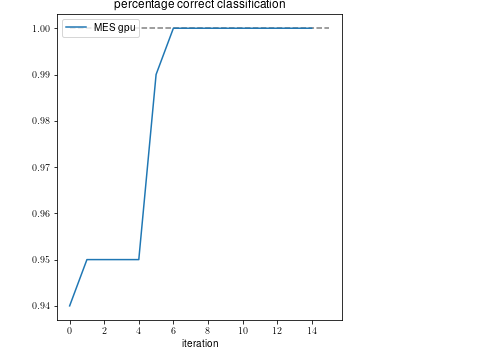

In [12]:
#print accuracy plot
from IPython.display import Image
filename=f"{os.getcwd()}/results/{timestampStr}/pct_correct_MES gpu_random.png"
Image(filename) 


In [13]:
#Let's visualize each iteration with a widget
import ipywidgets as widgets
from IPython.display import display
from IPython.html.widgets import interact
from natsort import natsorted

#load images
path = f"{os.getcwd()}/results/{timestampStr}"
imgs = list(filter(lambda fn:fn.startswith('1D'), os.listdir(path)))
imgs = natsorted(imgs, key=lambda y: y.lower())
def loadimg(k):
    display(Image(open(os.path.join(path,imgs[k]),'rb').read()))

#slider
w = widgets.IntSlider(
    min=0,
    max=len(imgs)-1,
    step=1,
    description='Iteration ',
    value=0
)
interact(loadimg, k = w);

interactive(children=(IntSlider(value=0, description='Iteration ', max=14), Output()), _dom_classes=('widget-i…

### Noisy observations

Excursion also has support for noisy observations of the black box function. The observations $y(\theta)$ are given by

$$
y(\theta) = f_{BB}(\theta) + \epsilon(x)
$$

The distribution $\epsilon(x)$ models the error we make when measuring $f_{BB}(x)$.
In this example we are going to use $\epsilon(x) \sim \mathcal{N}(0, \sigma^2)$ with $\sigma^2 = 1$.

X_init  tensor([2.0707, 5.0000], dtype=torch.float64)
y_init  [tensor([1.5118, 6.4362], dtype=torch.float64)]


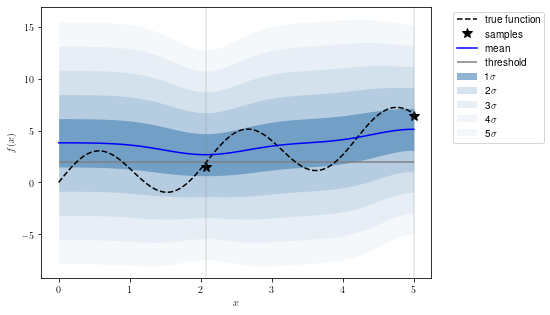

In [17]:
# REPEAT CASUAL USER COMMANDS
import excursion.testcases.fast_1D_noise as testcase_1d
# load specs 
file = open('../excursion/testcases/algorithms/algorithm_specs_noise.yaml', "r")
algorithm_opts = yaml.safe_load(file)

#initialize a GP
models, likelihood = init_gp(testcase_1d,  algorithm_opts,  device)
#save output
n_updates = 50
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y_%H:%M:%S") + "/"
outputfolder = "../examples/results/" +  timestampStr
os.makedirs(outputfolder)

#plot initialization
model = models[0]
plots.plot_GP(model, testcase_1d)

Iteration  1
x_new tensor([[2.0707]], dtype=torch.float64)
pct  0.59
Iteration  2
x_new tensor([[1.7172]], dtype=torch.float64)
pct  0.76
Iteration  3
x_new tensor([[1.0606]], dtype=torch.float64)
pct  0.71
Iteration  4
x_new tensor([[0.4040]], dtype=torch.float64)
pct  0.76
Iteration  5
x_new tensor([[2.2222]], dtype=torch.float64)
pct  0.78
Iteration  6
x_new tensor([[2.1212]], dtype=torch.float64)
pct  0.76
Iteration  7
x_new tensor([[0.7071]], dtype=torch.float64)
pct  0.77
Iteration  8
x_new tensor([[2.1717]], dtype=torch.float64)
pct  0.78
Iteration  9
x_new tensor([[0.7576]], dtype=torch.float64)
pct  0.77
Iteration  10
x_new tensor([[0.6566]], dtype=torch.float64)
pct  0.78
Iteration  11
x_new tensor([[0.8081]], dtype=torch.float64)
pct  0.79
Iteration  12
x_new tensor([[2.2727]], dtype=torch.float64)
pct  0.8
Iteration  13
x_new tensor([[2.0202]], dtype=torch.float64)
pct  0.79
Iteration  14
x_new tensor([[0.8586]], dtype=torch.float64)
pct  0.78
Iteration  15
x_new tensor([[0

<Figure size 432x288 with 0 Axes>

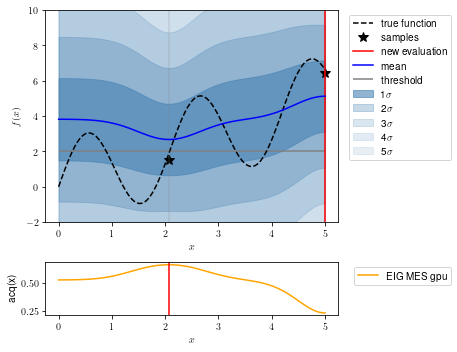

<Figure size 432x288 with 0 Axes>

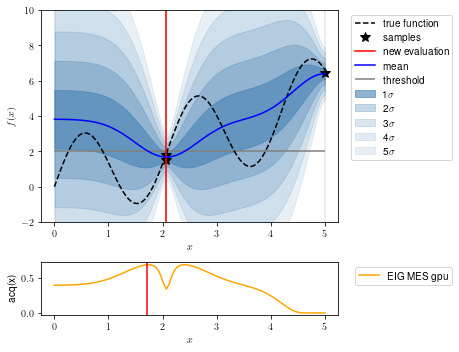

<Figure size 432x288 with 0 Axes>

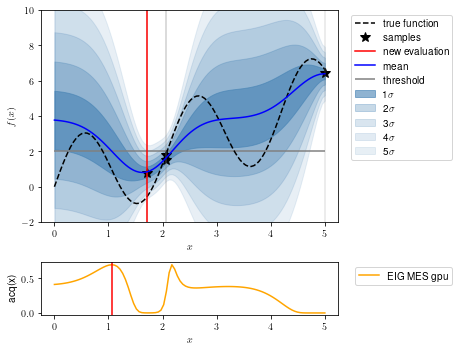

<Figure size 432x288 with 0 Axes>

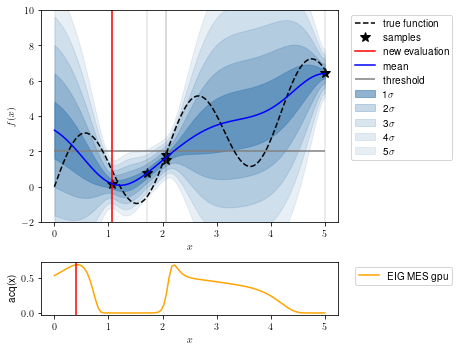

<Figure size 432x288 with 0 Axes>

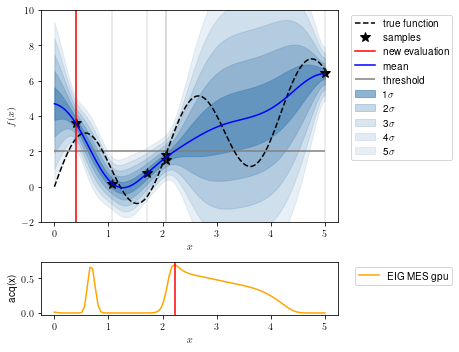

<Figure size 432x288 with 0 Axes>

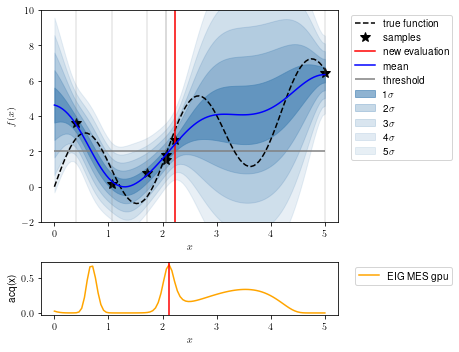

<Figure size 432x288 with 0 Axes>

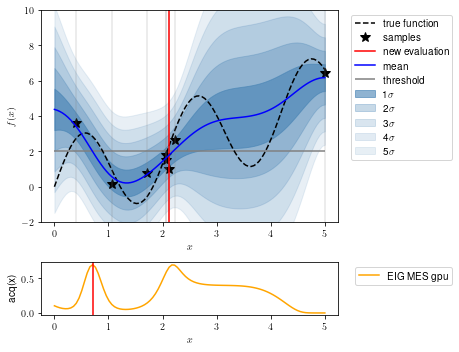

<Figure size 432x288 with 0 Axes>

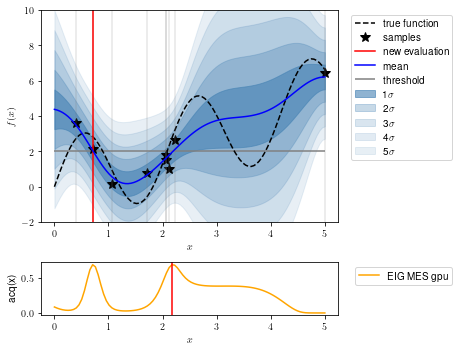

<Figure size 432x288 with 0 Axes>

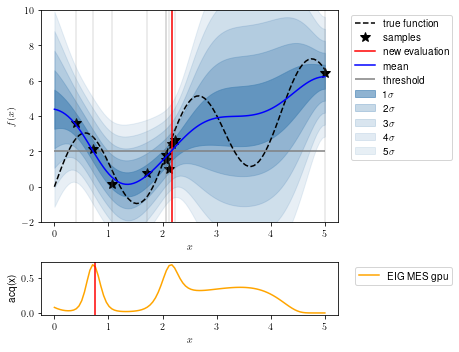

<Figure size 432x288 with 0 Axes>

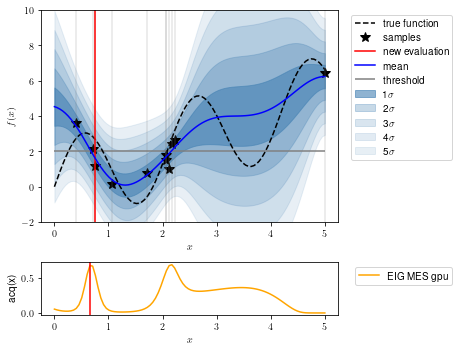

<Figure size 432x288 with 0 Axes>

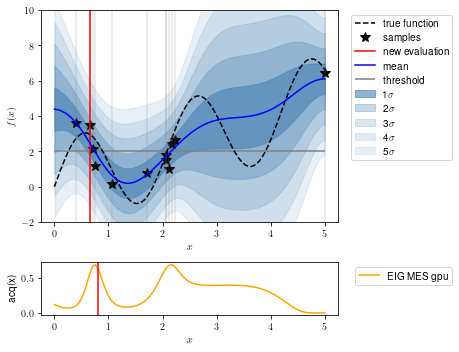

<Figure size 432x288 with 0 Axes>

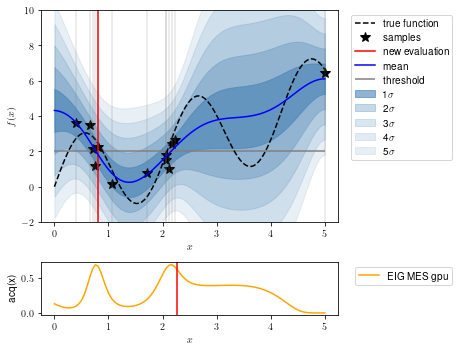

<Figure size 432x288 with 0 Axes>

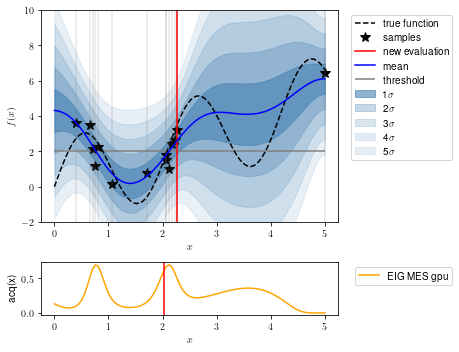

<Figure size 432x288 with 0 Axes>

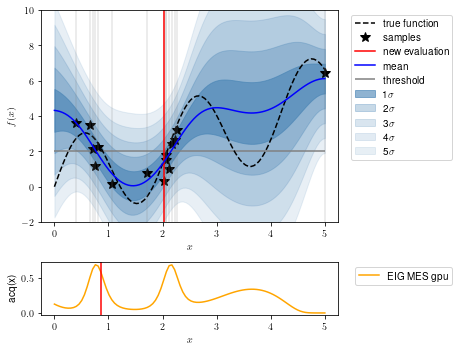

<Figure size 432x288 with 0 Axes>

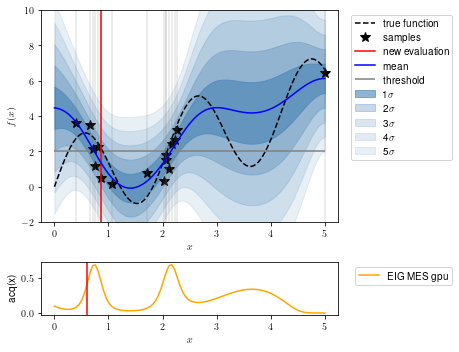

<Figure size 432x288 with 0 Axes>

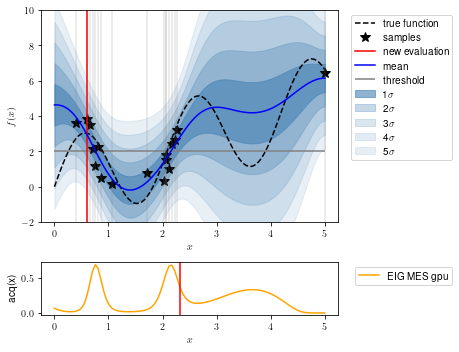

<Figure size 432x288 with 0 Axes>

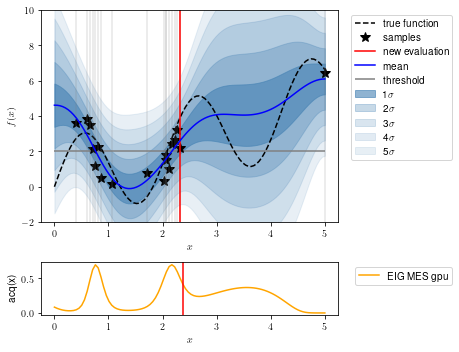

<Figure size 432x288 with 0 Axes>

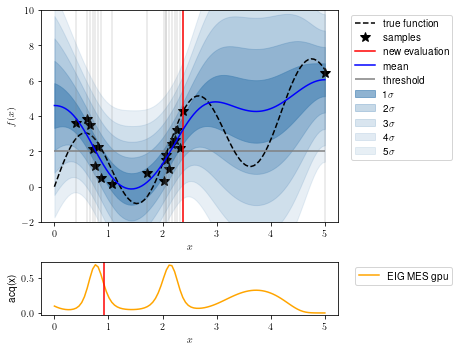

<Figure size 432x288 with 0 Axes>

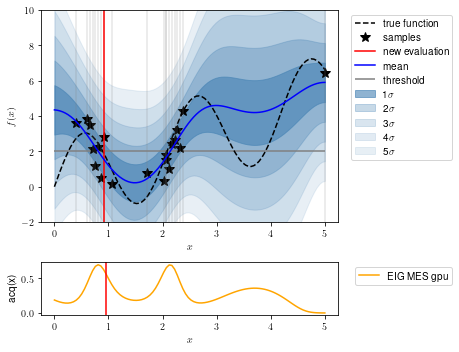

<Figure size 432x288 with 0 Axes>

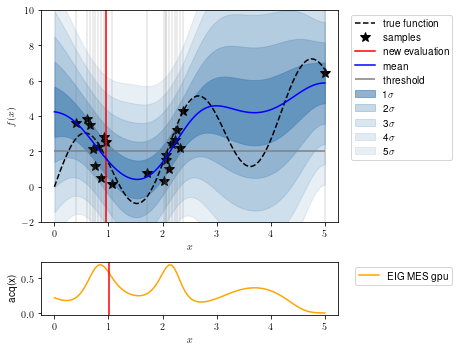

<Figure size 432x288 with 0 Axes>

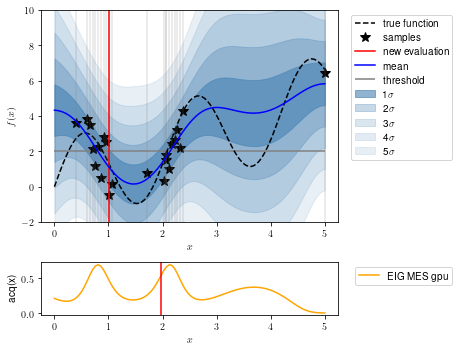

<Figure size 432x288 with 0 Axes>

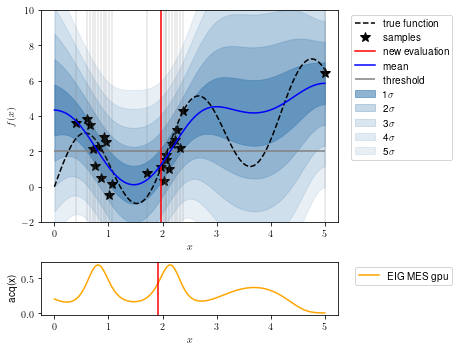

<Figure size 432x288 with 0 Axes>

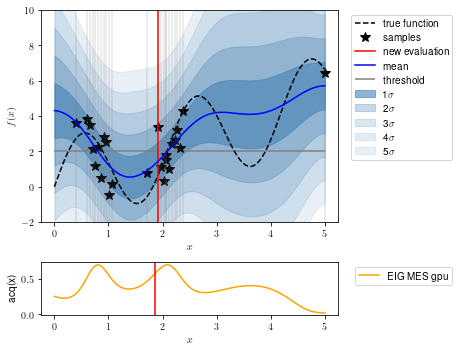

<Figure size 432x288 with 0 Axes>

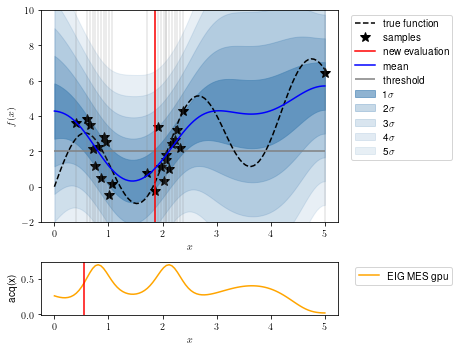

<Figure size 432x288 with 0 Axes>

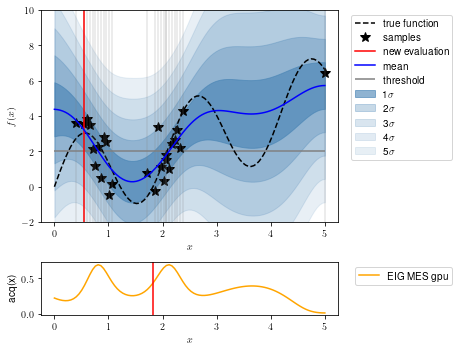

<Figure size 432x288 with 0 Axes>

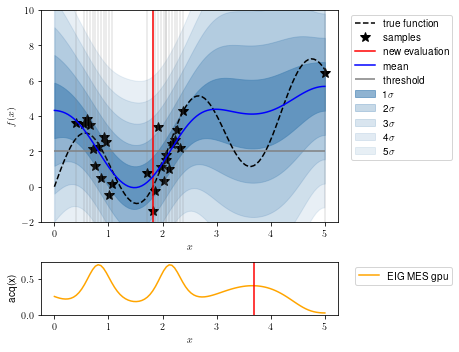

<Figure size 432x288 with 0 Axes>

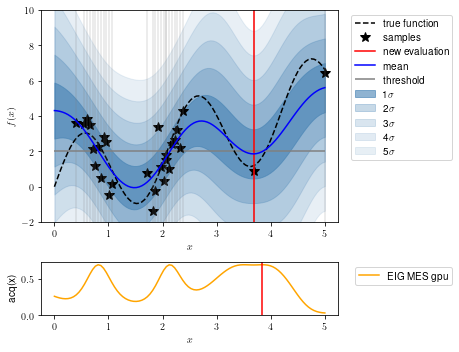

<Figure size 432x288 with 0 Axes>

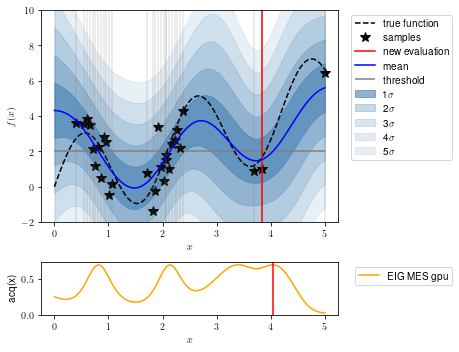

<Figure size 432x288 with 0 Axes>

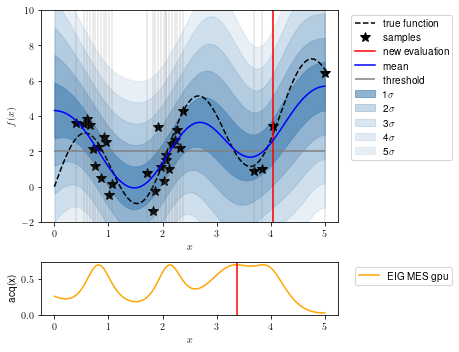

<Figure size 432x288 with 0 Axes>

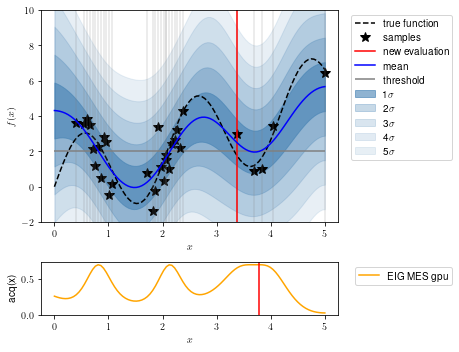

<Figure size 432x288 with 0 Axes>

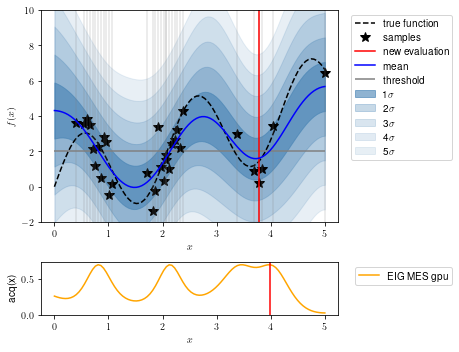

<Figure size 432x288 with 0 Axes>

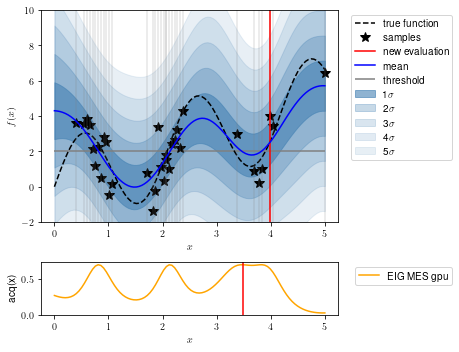

<Figure size 432x288 with 0 Axes>

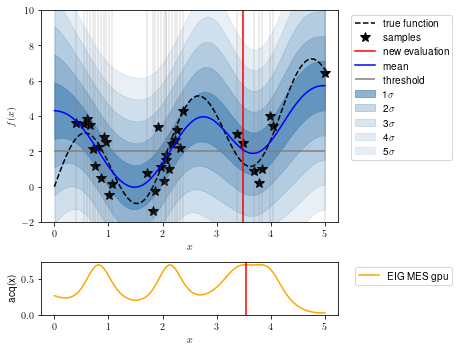

<Figure size 432x288 with 0 Axes>

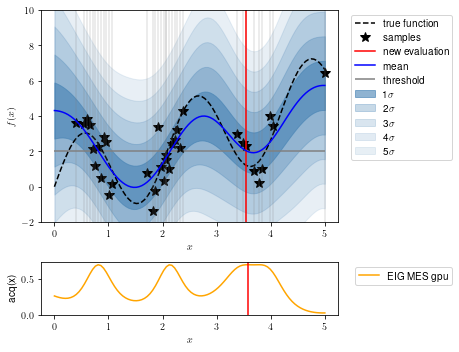

<Figure size 432x288 with 0 Axes>

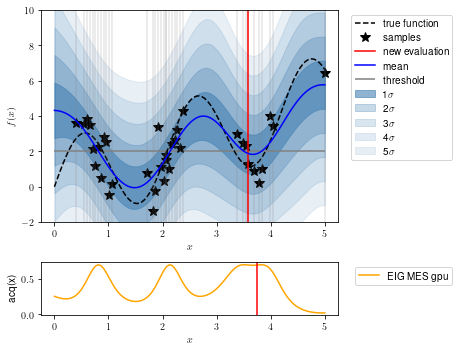

<Figure size 432x288 with 0 Axes>

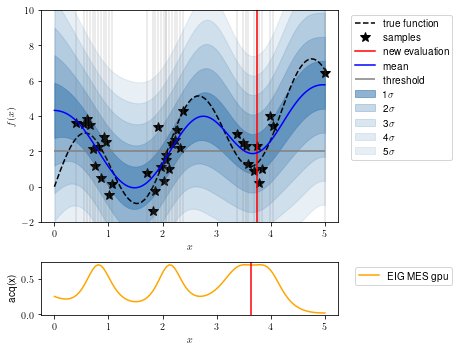

<Figure size 432x288 with 0 Axes>

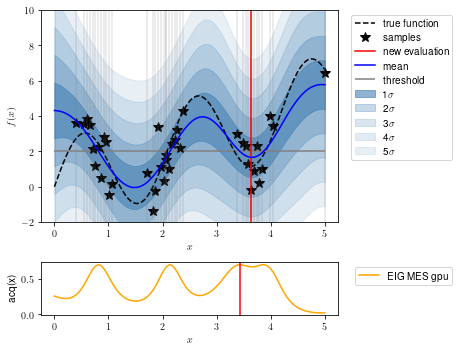

<Figure size 432x288 with 0 Axes>

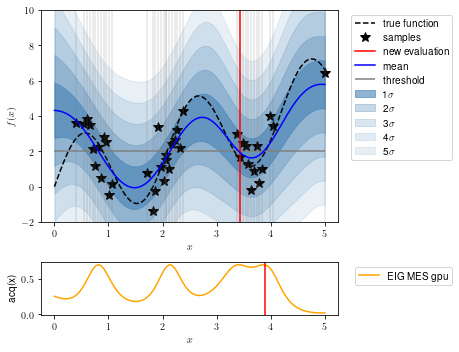

<Figure size 432x288 with 0 Axes>

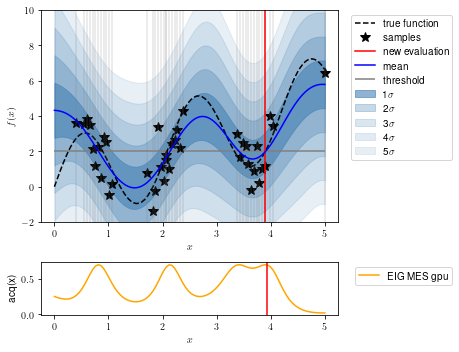

<Figure size 432x288 with 0 Axes>

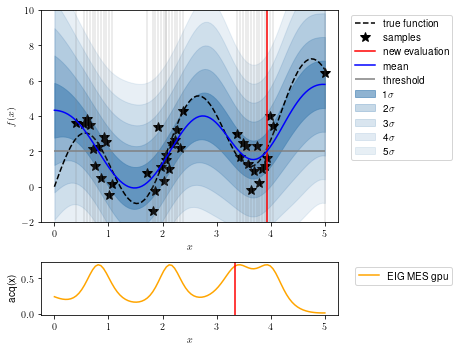

<Figure size 432x288 with 0 Axes>

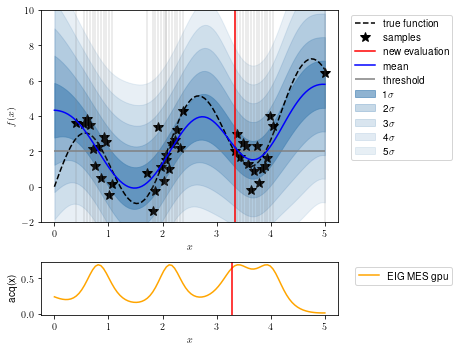

<Figure size 432x288 with 0 Axes>

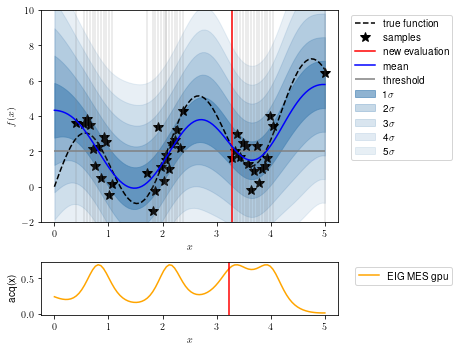

<Figure size 432x288 with 0 Axes>

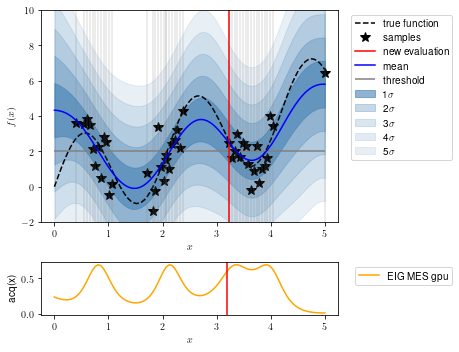

<Figure size 432x288 with 0 Axes>

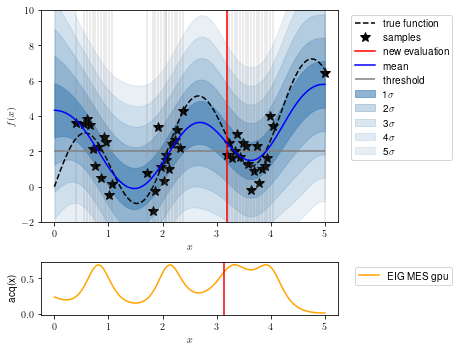

<Figure size 432x288 with 0 Axes>

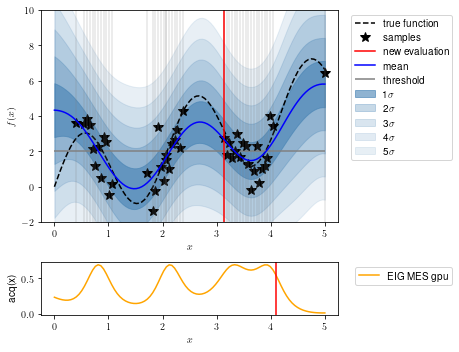

<Figure size 432x288 with 0 Axes>

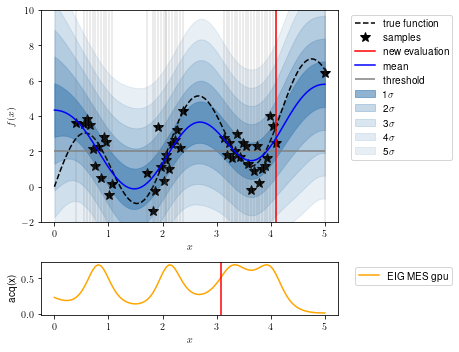

<Figure size 432x288 with 0 Axes>

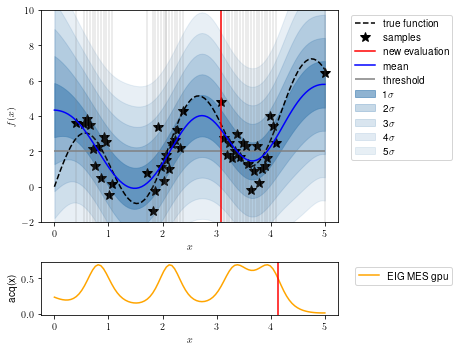

<Figure size 432x288 with 0 Axes>

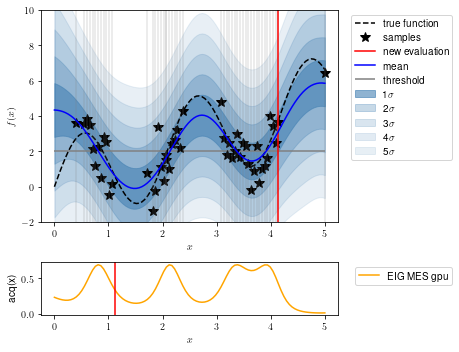

<Figure size 432x288 with 0 Axes>

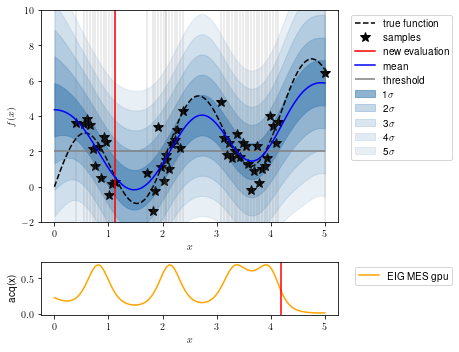

<Figure size 432x288 with 0 Axes>

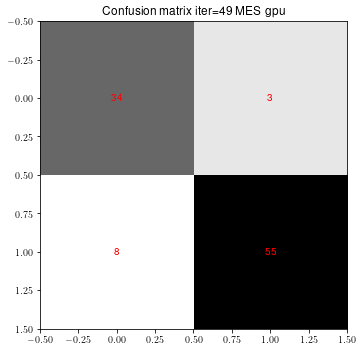

In [18]:
#run Active Learning
estimator = ExcursionSetEstimator(testcase_1d,    \
                                  algorithm_opts, \
                                  models,         \
                                  likelihood,     \
                                  device)

for iteration in range(1, n_updates+1):    
    estimator.step(testcase_1d, algorithm_opts, models, likelihood)
    estimator.plot_status(
            testcase_1d, algorithm_opts, models, estimator.acq_values, outputfolder);
    
    models = estimator.update_posterior(testcase_1d, algorithm_opts, models, likelihood)
    estimator.get_diagnostics(testcase_1d, models, likelihood)
    
estimator.print_results(outputfolder, testcase_1d, algorithm_opts)

In [19]:
#load images
path = f"{os.getcwd()}/results/{timestampStr}"
imgs = list(filter(lambda fn:fn.startswith('1D'), os.listdir(path)))
imgs = natsorted(imgs, key=lambda y: y.lower())
  
#slider
w = widgets.IntSlider(min=0, max=len(imgs)-1, step=1, description='Iteration ', value=0)
interact(loadimg, k = w);

interactive(children=(IntSlider(value=0, description='Iteration ', max=49), Output()), _dom_classes=('widget-i…

End of the 1D tutorial!

## 2D example with multiple functions <a class="anchor" id="2d"></a>

The package also ofers simultaneous level set estimation for two different functions. 
Note that the more similar the functions are, the less iterations are necessary to estimate all level sets.
With the exact same procedure as described above but in 2 dimensions we can achieve:


<img src="../assets/2d_pyhep.gif" alt="gif" title="2D animation" width="1300" height="400" class="center" />

### Example with batches of points

In [ ]:
import excursion.testcases.fast_2D as testcase_batches
file = open('../excursion/testcases/algorithms/algorithm_specs_batches.yaml', "r")
algorithm_opts = yaml.safe_load(file)

models, likelihood = init_gp(testcase_batches, algorithm_opts, device)

## TO DO

## 7. 4D example <a class="anchor" id="7"></a>


<picture of a 3D parabola surface circle>

In [60]:
import excursion.testcases.parabola_nD as testcase_circle
file = open('../excursion/testcases/algorithms/algorithm_specs_circle.yaml', "r")
algorithm_opts = yaml.safe_load(file)
models, likelihood = init_gp(testcase_circle, algorithm_opts, device)
model = models[0]

X_init  tensor([[-1.1111,  1.5556, -1.5556,  0.2222],
        [-1.1111, -1.1111,  0.2222, -2.0000],
        [-1.5556, -0.6667, -1.5556,  1.1111],
        [ 1.1111,  2.0000, -0.2222,  1.1111],
        [ 2.0000,  0.6667,  2.0000, -0.2222],
        [ 0.2222,  0.6667, -0.6667, -0.2222],
        [ 2.0000, -1.5556, -2.0000, -1.1111]], dtype=torch.float64)
y_init  [tensor([ 6.1235,  6.5185,  6.5185,  6.5185,  8.4938,  0.9877, 11.6543],
       dtype=torch.float64)]


Iteration  1
x_new tensor([[ 0.2222,  0.2222, -0.6667, -0.2222]], dtype=torch.float64)
pct  0.9826
Iteration  2
x_new tensor([[ 0.2222,  0.2222, -0.2222, -0.2222]], dtype=torch.float64)
pct  0.9828
Iteration  3
x_new tensor([[ 0.2222,  0.6667, -0.2222, -0.2222]], dtype=torch.float64)
pct  0.9828
Iteration  4
x_new tensor([[ 0.2222,  0.2222, -0.2222, -0.6667]], dtype=torch.float64)
pct  0.9829
Iteration  5
x_new tensor([[ 0.2222,  0.6667, -0.2222, -0.6667]], dtype=torch.float64)
pct  0.983
Iteration  6
x_new tensor([[ 0.2222,  0.2222, -0.6667, -0.6667]], dtype=torch.float64)
pct  0.9831
Iteration  7
x_new tensor([[ 0.6667,  0.2222, -0.2222, -0.2222]], dtype=torch.float64)
pct  0.9832
Iteration  8
x_new tensor([[ 0.6667,  0.2222, -0.6667, -0.2222]], dtype=torch.float64)
pct  0.9833
Iteration  9
x_new tensor([[ 0.6667,  0.2222, -0.2222, -0.6667]], dtype=torch.float64)
pct  0.9834
Iteration  10
x_new tensor([[ 0.6667,  0.6667, -0.2222, -0.2222]], dtype=torch.float64)
pct  0.9835
Iteration 

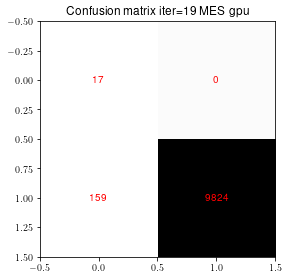

In [63]:
estimator = ExcursionSetEstimator(testcase_circle, algorithm_opts, models, likelihood, device)
n_updates = 20
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y_%H:%M:%S") + "/"
outputfolder = "../examples/results/" +  timestampStr
os.makedirs(outputfolder)

for iteration in range(1, n_updates+1):    
    estimator.step(testcase_circle, algorithm_opts, models, likelihood)
    models = estimator.update_posterior(testcase_circle, algorithm_opts, models, likelihood)
    estimator.get_diagnostics(testcase_circle, models, likelihood)
    
estimator.print_results(outputfolder, testcase_circle, algorithm_opts)

Let's try to make sense of the points the Active Learning loop has chosen. The points in the 3-sphere level set hold that
$x^2 + y^2 + z^2 = 1$. A histogram of the norm of the chosen points can help.

In [ ]:
distances = torch.norm(estimator.new_Xs, dim=1) #?
plt.hist(distances,grid=False)
plt.xlabel('$|| x ||$')
plt.ylabel('count')
## TO DO

## Bonus: hyperparameter evolution

Using excursion we can also retrieve which are the hyperparameters of the GP at each iteration of the Active Learning loop.
We can use the plots below for diagnostics and convergence.

<picture of hyperparameter evolution >

recall that $k(x, x') = C \exp\left( -\frac{|| x - x'||^2}{2 l^2}  \right)$

## Further work

- An IRIS-HEP fellow, Jason Hipkins, is working on a code refactoring and improving the library. Stay tuned and expect some changes!
  

- We are using excursion for an ongoing project with part of the Exotics group at ATLAS.
  

- There will be multiresolution support in the near future.
  

- We will explore how to leverage the features that BoTorch provides. This is particularly important for dimension scalability.
  
  
- We will include the possibility of querying black box functions that are external to the package. For instance, HEP simulators.